In [1]:
import pandas as pd
data=pd.read_csv("./datasets/english.csv")

In [2]:
txt=" ".join(data["sentence"])
txt.replace("-"," ")
mots=txt.split(" ")
vocab=list(set(mots))
id2word={i:v for i,v in enumerate(vocab) if v!=''}
word2id={v:i for i,v in enumerate(vocab) if v!=''}


In [3]:
def tokenize(vocabulary, target):
    tokenization = []
    for char in target:
        tokenization.append(vocabulary[char])
    return tokenization

def tokenize_dataset(exemples):
    tokenized_exemples=[tokenize(word2id,e.split(" ")) for e in exemples]
    return tokenized_exemples
def get_xy(seq):
    x = seq[:-1]
    y = seq[1:]
    return x, y


In [4]:
tokenized_dataset=tokenize_dataset(data["sentence"])

In [5]:
def aplypadding(objectif,liste):
    if len(liste)<objectif:
        differnce=objectif-len(liste)
        liste_dif=[-1 for _ in range(differnce)]
        liste.extend(liste_dif)
    if len(liste)>objectif:
        liste=liste[:objectif]

    return liste

In [6]:
def pad_dataset(exemples):
    tokenized_exemples=[aplypadding(70,e) for e in exemples]
    return tokenized_exemples

In [7]:
import torch
padded_data=pad_dataset(tokenized_dataset)
tokens=torch.tensor(padded_data)
import torch.nn as nn

In [8]:
tokens=torch.tensor(padded_data)
data = tokens[:, :-1]   # tout sauf le dernier
labels = tokens[:, 1:]    # tout sauf le premier


In [9]:
tokens=torch.tensor(padded_data)
data = tokens[:, :-1]   # tout sauf le dernier
labels = tokens[:, 1:]    
def split_data(x,y,test_size):
        indices = torch.randperm(len(x))
        size = int(len(x) *test_size)
        x = x[indices]
        y = y[indices]
        return x[:size], y[:size], x[size:], y[size:]


x_train,y_train,x_test,y_test=split_data(data,labels,0.25)
one_hot_y_train=torch.eye(len(vocab)+1)[y_train]
one_hot_y_test=torch.eye(len(vocab)+1)[y_test]

In [10]:
one_hot_y_train=torch.eye(len(vocab)+1)[y_train]
one_hot_y_test=torch.eye(len(vocab)+1)[y_test]

In [11]:
# Imports
import sys
sys.path.append("../")
import torch
from Rnn.Rnn_Layers import *
from core.model_structure import Deep_learning_Model
import core.metrics as M
import core.losses as Loss
from utils.data_manipulation import split_data
from core.MLp_layer import Layer
# Rnn_model spécialisation de Deep_learning_Model
class Rnn_model(Deep_learning_Model):
    def __init__(self, optimizer, loss):
        super().__init__(optimizer, loss)
    def forward_propagation(self,x):
        y=x
        for layer in self.layers:
         if isinstance(layer,Rnn_layer) or isinstance(layer,Gru) or isinstance(layer,LStm):
            y=layer.hidden_state(y)
         elif  isinstance(layer,Layer):
                y=layer.forward(y)
        return y
    


    def train_rnn_sgd(self, epochs, x_train, y_train, x_val, y_val, batch_size, learning_rate, accuracy=False):
        
        loop_plosses, loop_val_losses = [], []
        loop_accuracies, loop_val_accuracies = [], []
        num_batches = x_train.shape[0] // batch_size
        num_val_batches = x_val.shape[0] // batch_size

        for e in range(epochs):
            epoch_loss = []
            epoch_acc = []

            indices = torch.randperm(len(x_train))

            x_train, y_train = x_train[indices], y_train[indices]

            for i in range(num_batches):
                batch_losses = torch.tensor(0.0)
                batch_accs = 0.0

                start, end = i * batch_size, (i + 1) * batch_size
                x_batch, y_batch = x_train[start:end], y_train[start:end]
                

                batchtrain_embedings=self.layers[0].get_embedings(x_batch)

   
                for t in range(x_batch.shape[1]):
                    train_pred_t = self.forward_propagation(batchtrain_embedings[:, t, :])
                    lt = self.loss.compute_loss(train_pred_t, y_batch[:, t, :])
                    batch_losses += lt

                    if accuracy:
                        softmax_train_scores = self.loss.softmax(train_pred_t)

                        train_acc = M.accuracy(y_batch[:, t, :], softmax_train_scores)
                        batch_accs += train_acc


                batch_loss = batch_losses / x_batch.shape[1]
                batch_acc = batch_accs / x_batch.shape[1] if accuracy else None

                batch_loss.backward()

                with torch.no_grad():
                    self.backward_propagation(learning_rate, e+1)


                for l in self.layers:
                    if isinstance(l,Rnn_layer) or isinstance(l,Gru) or isinstance(l,LStm):
                     if l.ht is not None:
                        l.ht = l.ht.detach()
                    if  isinstance(l,LStm):
                        if l.ct is not None:
                            l.ct=l.ct.detach()
                
                


                epoch_loss.append(batch_loss.item())
                if accuracy:
                    epoch_acc.append(batch_acc)

            with torch.no_grad():
                val_losses = []
                val_accuracies = []

                for i in range(num_val_batches):
                    start, end = i * batch_size, (i + 1) * batch_size
                    x_val_batch, y_val_batch = x_val[start:end], y_val[start:end]
                    batch_loss = torch.tensor(0.0)
                    batch_acc = 0.0

                    batchval_embedings=self.layers[0].get_embedings(x_val_batch)

                    for t in range(x_val_batch.shape[1]):
                        val_pred_t = self.forward_propagation(batchval_embedings[:, t, :])
                        val_lt = self.loss.compute_loss(val_pred_t, y_val_batch[:, t, :])
                        batch_loss += val_lt

                        if accuracy:
                            softmax_val_scores = self.loss.softmax(val_pred_t)
                            
                            val_acc = M.accuracy(y_val_batch[:, t, :], softmax_val_scores)
                            batch_acc += val_acc

                    batch_loss /= x_val_batch.shape[1]
                    batch_acc = batch_acc / x_val_batch.shape[1] if accuracy else None

                    val_losses.append(batch_loss.item())
                    if accuracy:
                        val_accuracies.append(batch_acc)

                val_loss = sum(val_losses)
                val_acc = sum(val_accuracies) / num_val_batches if accuracy else None

            # Affichage des résultats epoch
            e_loss = sum(epoch_loss)


            loop_plosses.append(e_loss)
            loop_val_losses.append(val_loss)
            if accuracy:
                e_acc = sum(epoch_acc) / num_batches
                print(f"Epoch {e+1} | Train Loss: {e_loss:.4f} | Train Acc: {e_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
                loop_accuracies.append(e_acc)
                loop_val_accuracies.append(val_acc)
                

            else:
                print(f"Epoch {e+1} | Train Loss: {e_loss:.4f} | Val Loss: {val_loss:.4f}")
                

        if accuracy:
            return loop_plosses,loop_val_losses,loop_accuracies,loop_val_accuracies
        return loop_plosses,loop_val_losses



In [12]:

rnn_model = Rnn_model("adam", "Crossentropy")
rnn_model.add_layers([
    EmbeddingLayer(vocab_size=len(vocab), d_model=256),
    LStm(256,128),
    Layer(128,len(vocab)+1,"Xaviernormal",) ])


In [13]:
losses,val_losses,accuracies,val_accuracies = rnn_model.train_rnn_sgd(
    epochs=10,
    x_train=x_train,
    y_train=one_hot_y_train,
    x_val=x_test,
    y_val=one_hot_y_test,
    batch_size=32,
    learning_rate=0.001,
    accuracy=True
)

Epoch 1 | Train Loss: 0.0190 | Train Acc: 11.64% | Val Loss: 0.0539 | Val Acc: 81.58%
Epoch 2 | Train Loss: 0.0172 | Train Acc: 85.70% | Val Loss: 0.0486 | Val Acc: 86.10%
Epoch 3 | Train Loss: 0.0155 | Train Acc: 86.35% | Val Loss: 0.0438 | Val Acc: 86.26%
Epoch 4 | Train Loss: 0.0139 | Train Acc: 86.70% | Val Loss: 0.0393 | Val Acc: 86.34%
Epoch 5 | Train Loss: 0.0124 | Train Acc: 87.05% | Val Loss: 0.0354 | Val Acc: 86.40%
Epoch 6 | Train Loss: 0.0112 | Train Acc: 87.26% | Val Loss: 0.0320 | Val Acc: 86.45%
Epoch 7 | Train Loss: 0.0101 | Train Acc: 87.62% | Val Loss: 0.0289 | Val Acc: 86.48%
Epoch 8 | Train Loss: 0.0091 | Train Acc: 87.88% | Val Loss: 0.0260 | Val Acc: 86.54%
Epoch 9 | Train Loss: 0.0081 | Train Acc: 88.11% | Val Loss: 0.0233 | Val Acc: 86.55%
Epoch 10 | Train Loss: 0.0072 | Train Acc: 88.37% | Val Loss: 0.0208 | Val Acc: 86.58%


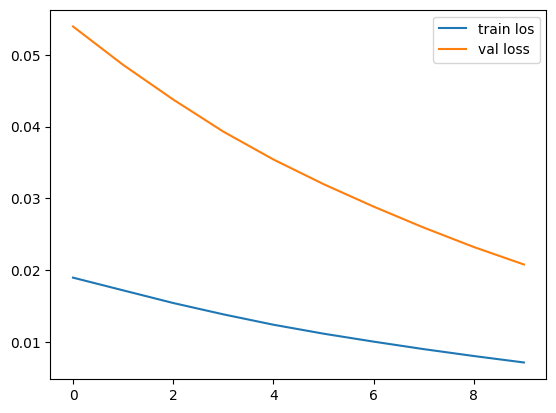

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(10),losses,label="train los")
plt.plot(range(10),val_losses,label="val loss")
plt.legend()

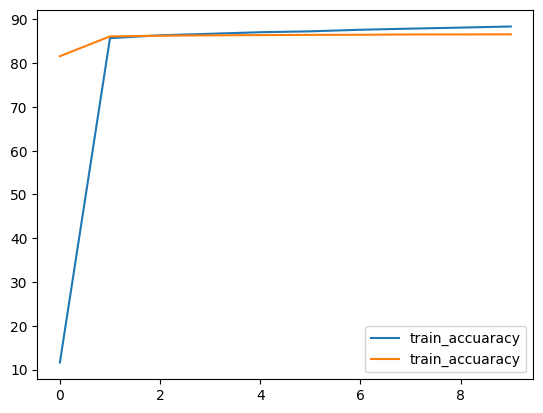

In [ ]:
plt.plot(range(10),accuracies,label="train_accuaracy")
plt.plot(range(10),val_accuracies,label="val_accuracies")
plt.legend()